<a href="https://colab.research.google.com/github/RAMGUNJAN/ERA1session8BN/blob/main/Assignment_8_Model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [2]:
# Import the necessary libraries
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Train Phase transformations
train_transforms = transforms.Compose([
    #transforms.RandomCrop(32, padding=4),  # Randomly crop the image with padding of 4 pixels
    #transforms.RandomHorizontalFlip(),     # Randomly flip the image horizontally
    transforms.ToTensor(),                  # Convert the image to a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image with mean and standard deviation
])

# Test Phase transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])




# Dataset and Creating Train/Test Split

In [3]:

# Load the CIFAR-10 dataset with the defined transformations
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:10<00:00, 15889861.57it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The model
Let's start with the model we first saw

In [5]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, dropout_value=0.1):
        super(Net, self).__init__()

        # Define the layers
        self.C1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=26, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(26),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        self.C2 = nn.Sequential(
            nn.Conv2d(in_channels=26, out_channels=52, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(52),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        self.C3 = nn.Sequential(
            nn.Conv2d(in_channels=52, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        self.P1 = nn.MaxPool2d(2, 2)

        self.C4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=26, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(26),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        self.C5 = nn.Sequential(
            nn.Conv2d(in_channels=26, out_channels=52, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(52),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        self.C6 = nn.Sequential(
            nn.Conv2d(in_channels=52, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        self.P2 = nn.MaxPool2d(2, 2)

        self.C7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=26, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(26),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        self.C8 = nn.Sequential(
            nn.Conv2d(in_channels=26, out_channels=52, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(52),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        self.C9 = nn.Sequential(
            nn.Conv2d(in_channels=52, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        self.GAP = nn.AdaptiveAvgPool2d(1)

        self.C10 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        )

    def forward(self, x):
        # Forward pass through the network
        x = self.C1(x)
        x = self.C2(x)
        x = self.C3(x)
        x = self.P1(x)
        x = self.C4(x)
        x = self.C5(x)
        x = self.C6(x)
        x = self.P2(x)
        x = self.C7(x)
        x = self.C8(x)
        x = self.C9(x)
        x = self.GAP(x)
        x = self.C10(x)
        x = x.view(x.size(0), -1)
        return x






In [6]:
from tqdm import tqdm
import torch.nn.functional as F

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        train_losses.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm
        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))



# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 26, 32, 32]             702
       BatchNorm2d-2           [-1, 26, 32, 32]              52
              ReLU-3           [-1, 26, 32, 32]               0
           Dropout-4           [-1, 26, 32, 32]               0
            Conv2d-5           [-1, 52, 32, 32]          12,168
       BatchNorm2d-6           [-1, 52, 32, 32]             104
              ReLU-7           [-1, 52, 32, 32]               0
           Dropout-8           [-1, 52, 32, 32]               0
            Conv2d-9           [-1, 10, 32, 32]             520
      BatchNorm2d-10           [-1, 10, 32, 32]              20
             ReLU-11           [-1, 10, 32, 32]               0
          Dropout-12           [-1, 10, 32, 32]               0

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [8]:

from torch.optim.lr_scheduler import StepLR

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)






EPOCH: 0


Loss=1.1634635925292969 Batch_id=390 Accuracy=41.84: 100%|██████████| 391/391 [00:23<00:00, 16.38it/s]



Test set: Average loss: 1.4989, Accuracy: 4220/10000 (42.20%)

EPOCH: 1


Loss=0.9375243186950684 Batch_id=390 Accuracy=58.49: 100%|██████████| 391/391 [00:17<00:00, 22.37it/s]



Test set: Average loss: 1.0573, Accuracy: 6273/10000 (62.73%)

EPOCH: 2


Loss=0.9289484024047852 Batch_id=390 Accuracy=63.23: 100%|██████████| 391/391 [00:17<00:00, 21.77it/s]



Test set: Average loss: 1.1244, Accuracy: 6027/10000 (60.27%)

EPOCH: 3


Loss=0.8871461749076843 Batch_id=390 Accuracy=66.31: 100%|██████████| 391/391 [00:17<00:00, 22.30it/s]



Test set: Average loss: 1.1553, Accuracy: 5890/10000 (58.90%)

EPOCH: 4


Loss=0.8023661375045776 Batch_id=390 Accuracy=68.14: 100%|██████████| 391/391 [00:18<00:00, 20.95it/s]



Test set: Average loss: 0.9774, Accuracy: 6510/10000 (65.10%)

EPOCH: 5


Loss=1.032166838645935 Batch_id=390 Accuracy=69.73: 100%|██████████| 391/391 [00:18<00:00, 21.40it/s]



Test set: Average loss: 1.0559, Accuracy: 6324/10000 (63.24%)

EPOCH: 6


Loss=0.7999674081802368 Batch_id=390 Accuracy=72.76: 100%|██████████| 391/391 [00:20<00:00, 19.54it/s]



Test set: Average loss: 0.8427, Accuracy: 7008/10000 (70.08%)

EPOCH: 7


Loss=0.6708888411521912 Batch_id=390 Accuracy=73.87: 100%|██████████| 391/391 [00:18<00:00, 20.60it/s]



Test set: Average loss: 0.8276, Accuracy: 7056/10000 (70.56%)

EPOCH: 8


Loss=0.6206169724464417 Batch_id=390 Accuracy=74.20: 100%|██████████| 391/391 [00:17<00:00, 21.94it/s]



Test set: Average loss: 0.8130, Accuracy: 7122/10000 (71.22%)

EPOCH: 9


Loss=0.6502412557601929 Batch_id=390 Accuracy=74.69: 100%|██████████| 391/391 [00:18<00:00, 21.13it/s]



Test set: Average loss: 0.8295, Accuracy: 7072/10000 (70.72%)

EPOCH: 10


Loss=0.97813880443573 Batch_id=390 Accuracy=74.92: 100%|██████████| 391/391 [00:17<00:00, 22.25it/s]



Test set: Average loss: 0.8086, Accuracy: 7156/10000 (71.56%)

EPOCH: 11


Loss=0.5770686864852905 Batch_id=390 Accuracy=75.08: 100%|██████████| 391/391 [00:17<00:00, 22.09it/s]



Test set: Average loss: 0.8278, Accuracy: 7070/10000 (70.70%)

EPOCH: 12


Loss=0.6408731937408447 Batch_id=390 Accuracy=75.52: 100%|██████████| 391/391 [00:18<00:00, 20.77it/s]



Test set: Average loss: 0.8038, Accuracy: 7183/10000 (71.83%)

EPOCH: 13


Loss=0.8114836812019348 Batch_id=390 Accuracy=75.61: 100%|██████████| 391/391 [00:19<00:00, 20.44it/s]



Test set: Average loss: 0.8100, Accuracy: 7149/10000 (71.49%)

EPOCH: 14


Loss=0.6738097071647644 Batch_id=390 Accuracy=75.70: 100%|██████████| 391/391 [00:18<00:00, 20.92it/s]



Test set: Average loss: 0.7913, Accuracy: 7209/10000 (72.09%)

EPOCH: 15


Loss=0.624613881111145 Batch_id=390 Accuracy=75.76: 100%|██████████| 391/391 [00:18<00:00, 20.59it/s]



Test set: Average loss: 0.7988, Accuracy: 7187/10000 (71.87%)

EPOCH: 16


Loss=0.4730076789855957 Batch_id=390 Accuracy=75.93: 100%|██████████| 391/391 [00:18<00:00, 21.65it/s]



Test set: Average loss: 0.7971, Accuracy: 7200/10000 (72.00%)

EPOCH: 17


Loss=0.7191077470779419 Batch_id=390 Accuracy=75.72: 100%|██████████| 391/391 [00:18<00:00, 21.44it/s]



Test set: Average loss: 0.7886, Accuracy: 7250/10000 (72.50%)

EPOCH: 18


Loss=0.7032328248023987 Batch_id=390 Accuracy=75.67: 100%|██████████| 391/391 [00:18<00:00, 21.16it/s]



Test set: Average loss: 0.7966, Accuracy: 7215/10000 (72.15%)

EPOCH: 19


Loss=0.7080988883972168 Batch_id=390 Accuracy=75.73: 100%|██████████| 391/391 [00:17<00:00, 21.84it/s]



Test set: Average loss: 0.8070, Accuracy: 7169/10000 (71.69%)



In [16]:
def get_misclassified_images(model, device, test_loader, num_images=10):
    misclassified_images = []
    misclassified_labels = []
    correct_labels = []

    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            misclassified_idx = ~pred.eq(target.view_as(pred))

            # Check if there are misclassified images in the batch
            if misclassified_idx.any():
                misclassified_images.extend(data[misclassified_idx.squeeze()])
                misclassified_labels.extend(pred[misclassified_idx.squeeze()])
                correct_labels.extend(target.view_as(pred)[misclassified_idx.squeeze()])

            if len(misclassified_images) >= num_images:
                break

    return misclassified_images[:num_images], misclassified_labels[:num_images], correct_labels[:num_images]

def plot_misclassified_images(images, predicted_labels, correct_labels):
    num_images = len(images)
    num_rows = num_images // 2
    fig, axs = plt.subplots(3, 2, figsize=(10, 15))
    fig.tight_layout()

    for i, ax in enumerate(axs.flat):
        ax.imshow(images[i].permute(1, 2, 0).cpu())
        ax.axis('off')
        ax.set_title(f'Predicted: {predicted_labels[i].item()}\nCorrect: {correct_labels[i].item()}')

    plt.show()












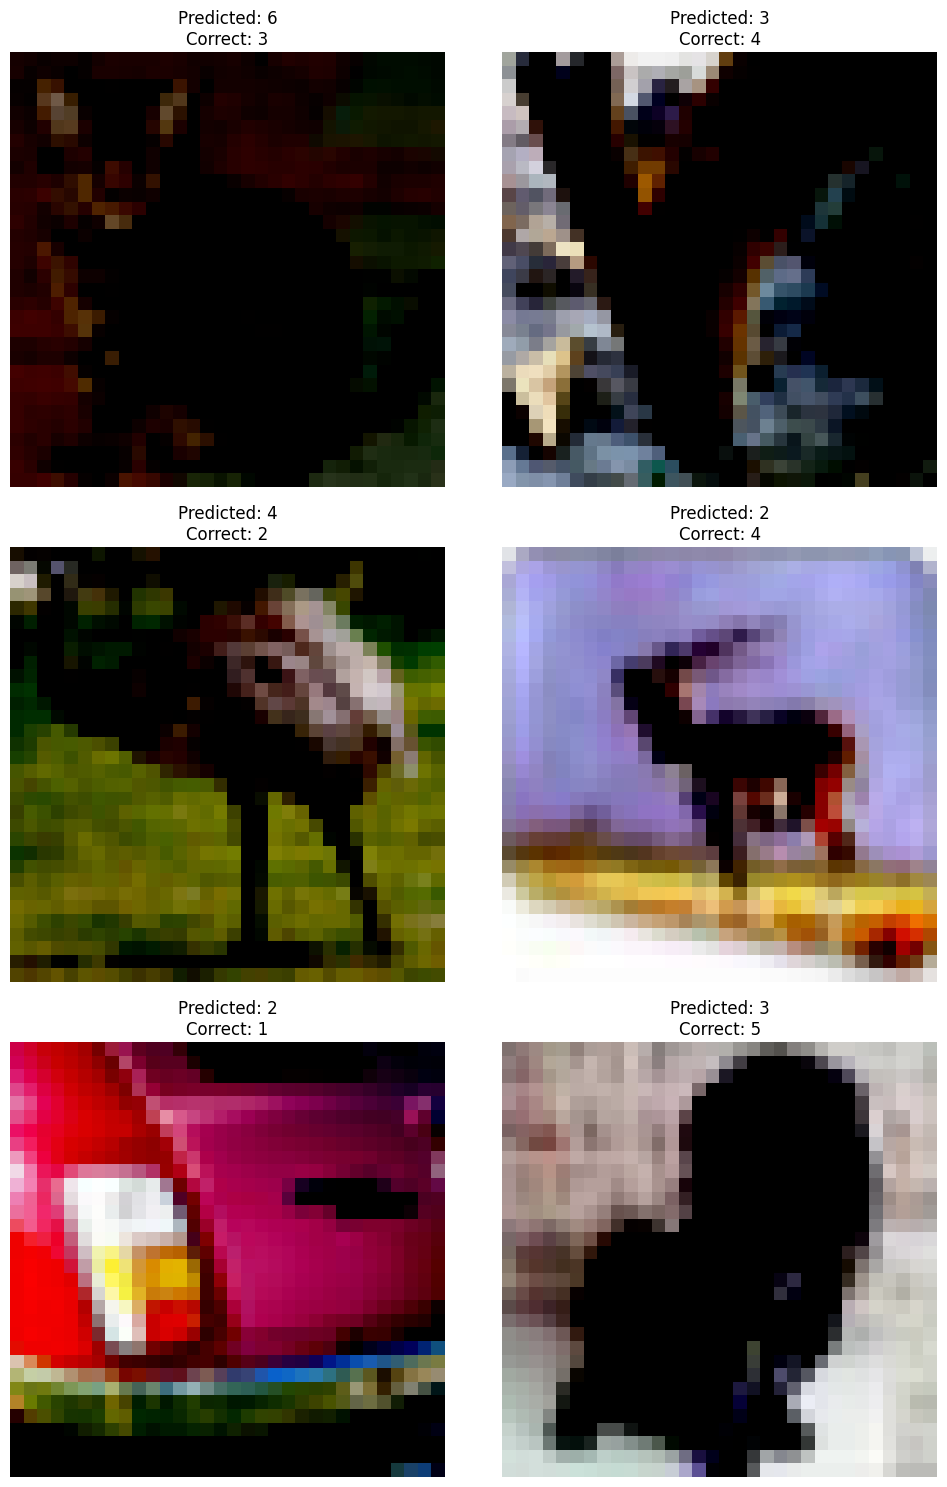

In [17]:
# Find misclassified images
misclassified_images, predicted_labels, correct_labels = get_misclassified_images(model, device, test_loader, num_images=10)

# Plot misclassified images
plot_misclassified_images(misclassified_images, predicted_labels, correct_labels)


In [18]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def save_misclassified_images(images, predicted_labels, correct_labels):
    for i, image in enumerate(images):
        plt.imshow(TF.to_pil_image(image))
        plt.axis('off')
        plt.title(f'Predicted: {predicted_labels[i].item()}\nCorrect: {correct_labels[i].item()}')
        plt.savefig(f'misclassified_image_{i+1}.png', bbox_inches='tight')
        plt.close()

# Save misclassified images
save_misclassified_images(misclassified_images, predicted_labels, correct_labels)


# Let's Train and test our model

This time let's add a scheduler for out LR.

Text(0.5, 1.0, 'Test Accuracy')

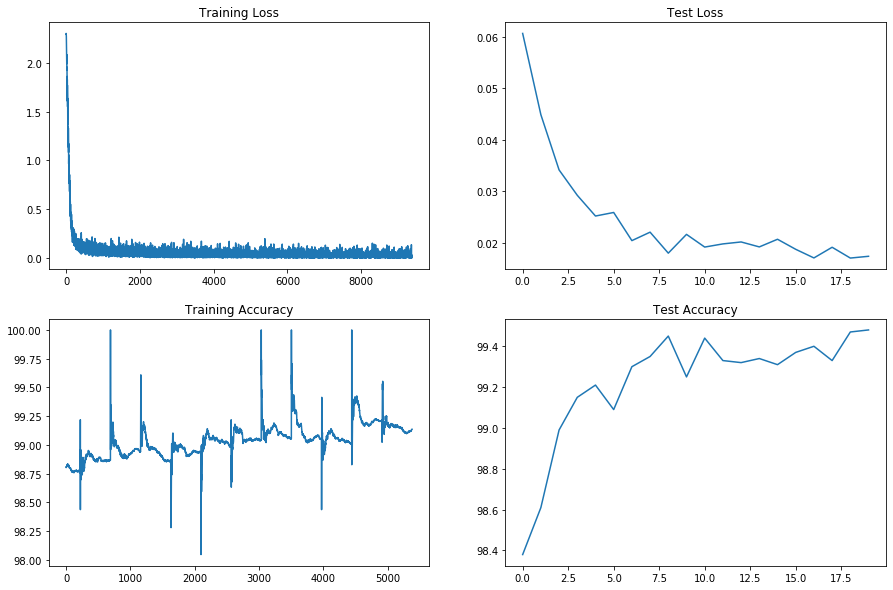

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

100%|██████████| 9912422/9912422 [00:00<00:00, 322384802.19it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 105061312.94it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 185248744.99it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5119733.61it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



RuntimeError: ignored